<a href="https://colab.research.google.com/github/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/blob/main/Project_3_Natural_Language_Processing_with_Reddit_Post.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id = 'section_0'><a/>
# 0.0 Function Creation
___

In [ ]:
# Platform Interface
import time
from time import sleep
import requests
import pickle

import pandas as pd
import numpy as np
import random
import itertools

# Visualisation Libraries
# !pip install --upgrade --quiet witwidget lime
# import lime
# import shap
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud

# ML Libraries
from nltk.tokenize import word_tokenize , sent_tokenize , RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix , plot_roc_curve , confusion_matrix
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow_hub as hub


pd.set_option('display.max_colwidth' , 300)

In [ ]:
def red_scrap(title):
    url = 'https://api.pushshift.io/reddit/search/submission'
    df_load = []
    params = {
        'subreddit': title,
        'size' : 100,
        'before': None
    }
    for i in range(15):
        # Access Reddit API
        res = requests.get(url,params)
        data = res.json()
        posts = data['data']
        
        
        df_new = pd.DataFrame(posts)
        df_load.append(df_new)
        
        # Initiating new time stamp (100th position of the 100 size) for before in params
        params['before'] = df_new['created_utc'][99]
        
        # Extract to CSV
        df = pd.concat(df_load, ignore_index = True)
        df.to_csv(f'{title}.csv')
        time.sleep(10)
        print(f'{i+1} Iterations completed')
        
    return df

In [ ]:
def date_conversion(df , column):

    time_value = []
    for value in df[column]:
        time_value.append(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(value)))
        
    df[column] = time_value
    df[[column]] = df[[column]].astype('datetime64[ns]')
    return df

In [83]:
def ngram_generator(df , ngram , subreddit = None):
  
  """
  This function contains 2 actions in order to process the word into visualiation base on the ngram count.
  1. CountVectorize & Transform Data
  2. Convert Data back to Matrix
  """
  
  if subreddit == None:
    cvec = CountVectorizer(ngram_range=(ngram,ngram))
    cvec.fit(df['title'])
    transformed = cvec.transform(df['title'])

  if subreddit == 'fake':
    cvec = CountVectorizer(ngram_range = (ngram,ngram))
    cvec.fit(df[df['subreddit'] == 0]['title'])
    transformed = cvec.transform(df[df['subreddit'] == 0]['title'])

  elif subreddit == 'world':
    cvec = CountVectorizer(ngram_range = (ngram,ngram))
    cvec.fit(df[df['subreddit'] == 1]['title'])
    transformed = cvec.transform(df[df['subreddit'] == 1]['title'])

  df_transformed = pd.DataFrame(transformed.todense(),
                                columns = cvec.get_feature_names())
  
  return df_transformed

In [84]:
def ngram_visualizer(df1 , df2 , df3):

  '''
  df1 = Main DF
  df2 = Fakenews
  df3 = Worldnews
  '''
  fig , ax = plt.subplots(1 , 3 , figsize = (20,9))

  df1.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[0])
  ax[0].set_title('Trending Words in All Subreddit Post' , fontsize = 14);

  df2.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[1] , color = 'lightblue')
  ax[1].set_title('Trending Words in FAKENEWS Subreddit Post' , fontsize = 14);

  df3.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[2] , color = 'green')
  ax[2].set_title('Trending Words in WORLDNEWS Subreddit Post' , fontsize = 14);

In [ ]:
def eval_classification(y_true , y_pred):

    from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score

    # Define Scoring variables
    accuracy = accuracy_score(y_true , y_pred)
    precision = precision_score(y_true , y_pred)
    recall = recall_score(y_true , y_pred)
    f1_score = f1_score(y_true , y_pred)

    score_dict = {'Accuracy' : accuracy,
                'Precision' : precision,
                'Recall' : recall,
                'F1 Score' : f1_score}

    return score_dict

In [ ]:
import datetime

def create_tensorboard_callback(dir_name , experiment_name):
  log_dir = dir_name +'/' + experiment_name +'/' +datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving Tensorboard log files to {log_dir}')
  return tensorboard_callback

In [ ]:
def tf_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# df_fakenews = red_scrap('fakenews')

In [ ]:
# df_worldnews = red_scrap('worldnews')

In [ ]:
tf.config.list_physical_devices('GPU')
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



<a id = 'section_1'><a/>
# 1.0 Data Exploration
___
[(back to top)](#content)

In [ ]:
!wget https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/fakenews.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/worldnews.csv

--2021-09-14 12:07:18--  https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/fakenews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3523846 (3.4M) [text/plain]
Saving to: ‘fakenews.csv’

fakenews.csv        100%[===================>]   3.36M  --.-KB/s    in 0.02s   

2021-09-14 12:07:18 (177 MB/s) - ‘fakenews.csv’ saved [3523846/3523846]

--2021-09-14 12:07:18--  https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/worldnews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP reques

In [ ]:
# Fake News Reddit
df_fakenews = pd.read_csv('/content/fakenews.csv')
df_fakenews = df_fakenews[['title' , 'subreddit' , 'created_utc']]
df_fakenews = date_conversion(df_fakenews , 'created_utc')

# World News Reddit
df_worldnews = pd.read_csv('/content/worldnews.csv')
df_worldnews = df_worldnews[['title' , 'subreddit' , 'created_utc']]
df_worldnews = date_conversion(df_worldnews , 'created_utc')

In [ ]:
print(f'No. of Fakenews Datasets : {len(df_fakenews)}')
print(f'Shape of Fakenews Datasets : {df_fakenews.shape}')

print(f'No. of World News Datasets : {len(df_worldnews)}')
print(f'Shape of World News Datasets : {df_worldnews.shape}')

No. of Fakenews Datasets : 1500
Shape of Fakenews Datasets : (1500, 3)
No. of World News Datasets : 1400
Shape of World News Datasets : (1400, 3)


### 1.1 Checking for Duplicates and Null
___

In [ ]:
print(f'No. of Duplicate Cell : {df_fakenews.duplicated().sum()}')
print(f'No. of Null Cell : {df_fakenews.isnull().sum().sum()}')
df_fakenews.drop_duplicates(inplace = True)
print(f'No. of Duplicate Cell After Remove Duplicate : {df_fakenews.duplicated().sum()}')

No. of Duplicate Cell : 1
No. of Null Cell : 0
No. of Duplicate Cell After Remove Duplicate : 0


In [ ]:
print(f'No. of Duplicate Cell : {df_worldnews.duplicated().sum()}')
print(f'No. of Null Cell : {df_worldnews.isnull().sum().sum()}')

No. of Duplicate Cell : 0
No. of Null Cell : 0


### 1.2 Visualing Some Random Text
___

In [ ]:
# Visualing Some Random Post from Fake News
random_sentences = random.sample(df_fakenews['title'].to_list() , 10)
for index , sentence in enumerate(random_sentences):
    print(index , sentence)

0 The snowstorm backlog debunks this article
1 A holistic approach in tackling fake news and misinformation?
2 Portland antifa journalist @donovanfarley claimed he was beaten by police for “doing his job.” A damning investigation examining video found his claims “demonstrably inaccurate.”Even the DA declined to prosecute the officer.
3 FAKE NEWS | Hero dog that chased down ISIS founder runs for President
4 😍 Porn 💘 Server Invite ❤️
5 Canceled White People to be Relocated to Town in Antarctica - The Scornful Jest
6 What are the least credible sources for COVID-19 information?
7 Calling Everything Fake News
8 Fakenews
9 Wait.. what?


In [ ]:
# Visualing Some Random Post from World News
random_sentences = random.sample(df_worldnews['title'].to_list() , 10)
for index , sentence in enumerate(random_sentences):
    print(index , sentence)

0 Israel captures four of six Palestinian jail breakers
1 Lithuania expels Afghanistan migrants despite European Court stand
2 Simi Responds To News Of Her Betraying MC Morris
3 Top 10 freelance websites for beginners
4 Pfizer and BioNTech will soon seek clearance for vaccine use in children 5 and older.
5 Chinese social media site Weibo suspends 22 K-pop accounts
6 Peru: Abimael Guzmán, head of Shining Path insurgency, dies
7 Republicans Already Lying That California's Recall Election Is 'Rigged'
8 No place for new fossil fuels if world is to reach net zero by 2050, says landmark report
9 Sony PlayStation 4 500GB Jet Black Console Plus (FREE controller ) on sale !!! Click on picture


# 2.0 Data Cleaning and Preprocessing
___

In [ ]:
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

port_stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 2.1 TextVectorizer Input and Visualize Random Sentence
___

In [ ]:
'''
1. Standardize each example (usually lowercasing + punctuation stripping)
2. Split each example into substrings (usually words)
3. Recombine substrings into tokens (usually ngrams)
'''
random_sentences = random.sample(df_fakenews['title'].to_list() , 3)

for sentence in random_sentences:
    
    # Print Before Split
    print('Original Sentence                : ' , sentence)

    # Remove Numeric Number , lower words
    regex_token = RegexpTokenizer(r'[a-zA-Z]\w+')
    sent_split = regex_token.tokenize(sentence.lower())
    print('Remove Numeric , lowercase       : ' , sent_split)
    
    # Stripped the Punctuation
    sent_split = [word for word in sent_split if word not in (string.punctuation)]
    print('Remove Punctuation               : ' , sent_split)

    # Remove Stop words
    sent_split = [word for word in sent_split if word not in (stop_words)]
    print('Remove Stop words                : ' , sent_split)

    # Stem the words and joint back  
    joint = ' '.join([port_stemmer.stem(word) for word in sent_split])
    print('Stem the words & joint the words : ' , joint)
    print('-----------------------------------------')
    

Original Sentence                :  I dont see a 25% increase in PA.
Remove Numeric , lowercase       :  ['dont', 'see', 'increase', 'in', 'pa']
Remove Punctuation               :  ['dont', 'see', 'increase', 'in', 'pa']
Remove Stop words                :  ['dont', 'see', 'increase', 'pa']
Stem the words & joint the words :  dont see increas pa
-----------------------------------------
Original Sentence                :  Quote about fake news from 3000 years ago
Remove Numeric , lowercase       :  ['quote', 'about', 'fake', 'news', 'from', 'years', 'ago']
Remove Punctuation               :  ['quote', 'about', 'fake', 'news', 'from', 'years', 'ago']
Remove Stop words                :  ['quote', 'fake', 'news', 'years', 'ago']
Stem the words & joint the words :  quot fake news year ago
-----------------------------------------
Original Sentence                :  Fake news vs real news experiment
Remove Numeric , lowercase       :  ['fake', 'news', 'vs', 'real', 'news', 'experiment']
Remo

### 2.2 Preprocess Function for data
___

In [ ]:
def preprocessing(df , col):
    
    sentence_process = []
    for sentence in df[col]:
               
        # Remove Numeric Number , lower words
        regex_token = RegexpTokenizer(r'[a-zA-Z]\w+')
        sent_split = regex_token.tokenize(sentence.lower())
        
        # Stripped the Punctuation
        sent_split = [word for word in sent_split if word not in (string.punctuation)]

        # Remove Stop words
        sent_split = [word for word in sent_split if word not in (stop_words)]

        # Stem the words and joint back  
        joint = ' '.join([port_stemmer.stem(word) for word in sent_split])        
    
        sentence_process.append(joint)
    
    df[col] = sentence_process

In [ ]:
preprocessing(df_fakenews , 'title')

In [ ]:
df_fakenews.head()

,title,subreddit,created_utc
0,research show great awoken media preced trump outlast opinion,fakenews,2021-09-11 13:37:46
1,get paid china stir panic,fakenews,2021-09-10 18:52:00
2,fact check journalist spread misinform wi spa,fakenews,2021-09-10 16:25:26
3,afghani central bank governor imag goe viral real asia market,fakenews,2021-09-10 13:48:40
4,stori mike emm real,fakenews,2021-09-08 21:29:04


In [ ]:
preprocessing(df_worldnews , 'title')

In [ ]:
df_worldnews.head()

,title,subreddit,created_utc
0,mari trump say disgrac uncl spend comment box match,worldnews,2021-09-12 06:20:04
1,next fast food chicken sandwich war may fake one,worldnews,2021-09-12 06:11:44
2,revis belgium histori call first ebola outbreak congo,worldnews,2021-09-12 06:00:46
3,democrat build big edg earli vote,worldnews,2021-09-12 05:59:43
4,ch51 ch51,worldnews,2021-09-12 05:59:42


### 2.3 Removing Data Leakage
___

In [ ]:
# DF Fake News
print('Data Count Before removal leaked words:' , len(df_fakenews))
df_fakenews = df_fakenews.loc[~df_fakenews['title'].str.contains('fake|news|new|say')]
df_fakenews.head()
print('Data Count After removal leaked words:' , len(df_fakenews))

Data Count Before removal leaked words: 1499
Data Count After removal leaked words: 958


In [ ]:
print('Data Count Before removal leaked words:' , len(df_worldnews))
df_worldnews = df_worldnews.loc[~df_worldnews['title'].str.contains('world|news|new|say')]
df_worldnews.head()
print('Data Count After removal leaked words:' , len(df_worldnews))

Data Count Before removal leaked words: 1400
Data Count After removal leaked words: 1166


### 2.4 Merging Datasets
___

In [ ]:
df_main = pd.concat([df_fakenews , df_worldnews])
df_main.drop('created_utc' , inplace=True , axis = 1)

print(f'No. of Combined Datasets : {len(df_main)}')
print(f'Shape of Combined Datasets : {df_main.shape}')
print(f'SIze of Combined Datasets : {df_main.size}')

No. of Combined Datasets : 2124
Shape of Combined Datasets : (2124, 2)
SIze of Combined Datasets : 4248


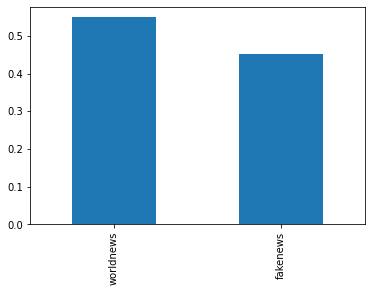

In [ ]:
df_main['subreddit'].value_counts(normalize = True).plot(kind = 'bar');

In [ ]:
dict_reddit = {'fakenews' : 0,
               'worldnews' : 1}

df_main['subreddit'] = df_main['subreddit'].map(dict_reddit)

### 2.5 Removing Sentence with only 1 word
___

In [ ]:
df_main['len of sentence'] = [len(sentence.split(' ')) for sentence in df_main['title']]

In [ ]:
print('No. of Sentence with 1 word :' , len(df_main[df_main['len of sentence'] == 1]))
print('Longest Sentence :' , df_main['len of sentence'].max())
df_main[df_main['len of sentence'] == 1].head(10)

No. of Sentence with 1 word : 136
Longest Sentence : 46


,title,subreddit,len of sentence
11,,0,1
31,hhhmmm,0,1
40,propaganda,0,1
58,reddit,0,1
116,guid,0,1
157,make,0,1
166,cnn,0,1
193,,0,1
220,real,0,1
245,world,0,1


In [ ]:
df_main = df_main[df_main['len of sentence'] > 2]

In [ ]:
# !pip install unidecode
# import unidecode

### 2.6 Visualising Popular Words
___

In [ ]:
# Inistantiating Count Vectorizer
cvec = CountVectorizer(ngram_range=(1,3) , n)
cvec.fit(df_main['title'])
main = cvec.transform(df_main['title'])

cvec_fake = CountVectorizer(ngram_range = (1,3))
cvec_fake.fit(df_main[df_main['subreddit'] == 0]['title'])
fake = cvec_fake.transform(df_main[df_main['subreddit'] == 0]['title'])

cvec_world = CountVectorizer(ngram_range = (1,3))
cvec_world.fit(df_main[df_main['subreddit'] == 1]['title'])
world = cvec_world.transform(df_main[df_main['subreddit'] == 1]['title'])

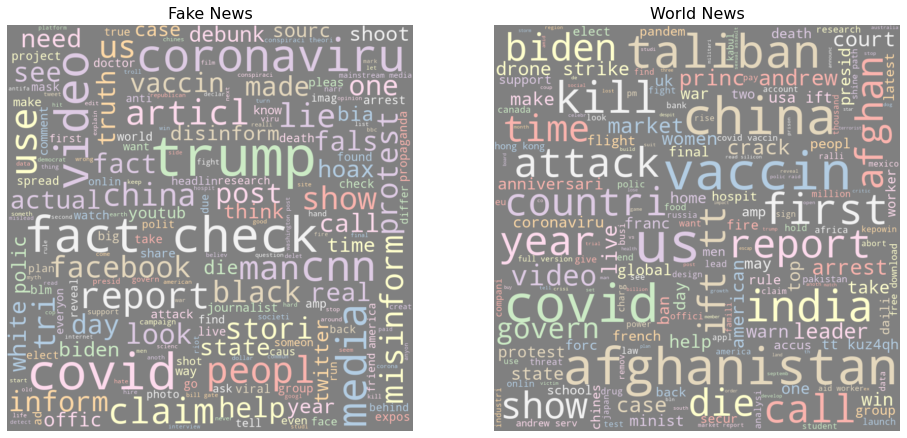

In [ ]:
# Word cloud for news

word_fake = ' '.join([word for word in df_main[df_main['subreddit'] == 0]['title']])
word_world = ' '.join([word for word in df_main[df_main['subreddit'] == 1]['title']])

wordcloud_fake = WordCloud(width= 800, 
                          height= 800,
                          max_font_size = 110,
                          collocations = True,
                          background_color = 'grey',
                          colormap= 'Pastel1').generate(word_fake)

wordcloud_world = WordCloud(width= 800, 
                            height= 800,
                            max_font_size = 110,
                            collocations = True,
                            background_color = 'grey',
                            colormap= 'Pastel1').generate(word_world)                      

plt.figure(figsize=(16,12))
plt.subplot(1,2,1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.title('Fake News' , fontsize = 16)

plt.subplot(1,2,2)
plt.imshow(wordcloud_world, interpolation='bilinear')
plt.axis("off")
plt.title('World News' , fontsize = 16);

In [ ]:
# Interestingly the vocab from each DF summed up is not equal to the vocab from the merged DF
df_main_vocab = pd.DataFrame(main.todense(),
                             columns = cvec.get_feature_names())

df_fake_vocab = pd.DataFrame(fake.todense(),
                             columns = cvec_fake.get_feature_names())

df_world_vocab = pd.DataFrame(world.todense(),
                              columns = cvec_world.get_feature_names())

print(f'DF Shape for Main Vocab :' , df_main_vocab.shape)
print(f'DF Shape for fakenews Vocab  :' , df_fake_vocab.shape)
print(f'DF Shape for worldnews Vocab  :' , df_world_vocab.shape)

DF Shape for Main Vocab : (1866, 27265)
DF Shape for fakenews Vocab  : (786, 11555)
DF Shape for worldnews Vocab  : (1080, 17022)


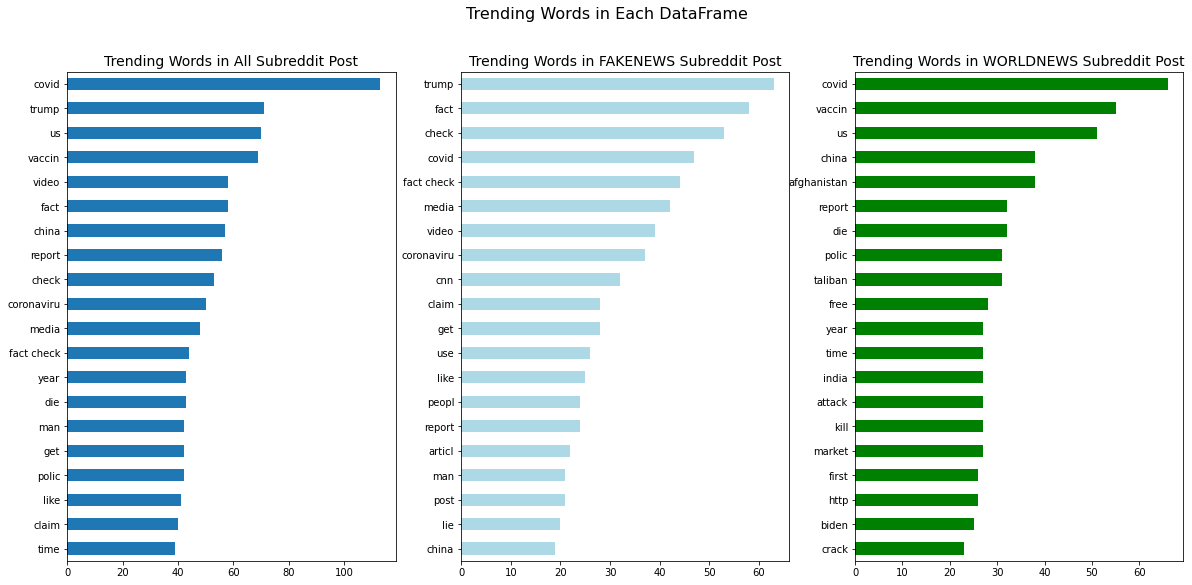

In [ ]:
fig , ax = plt.subplots(1 , 3 , figsize = (20,9))

df_main_vocab.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[0])
ax[0].set_title('Trending Words in All Subreddit Post' , fontsize = 14);

df_fake_vocab.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[1] , color = 'lightblue')
ax[1].set_title('Trending Words in FAKENEWS Subreddit Post' , fontsize = 14);

df_world_vocab.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[2] , color = 'green')
ax[2].set_title('Trending Words in WORLDNEWS Subreddit Post' , fontsize = 14);

plt.suptitle('Trending Words in Each DataFrame' , fontsize = 16);

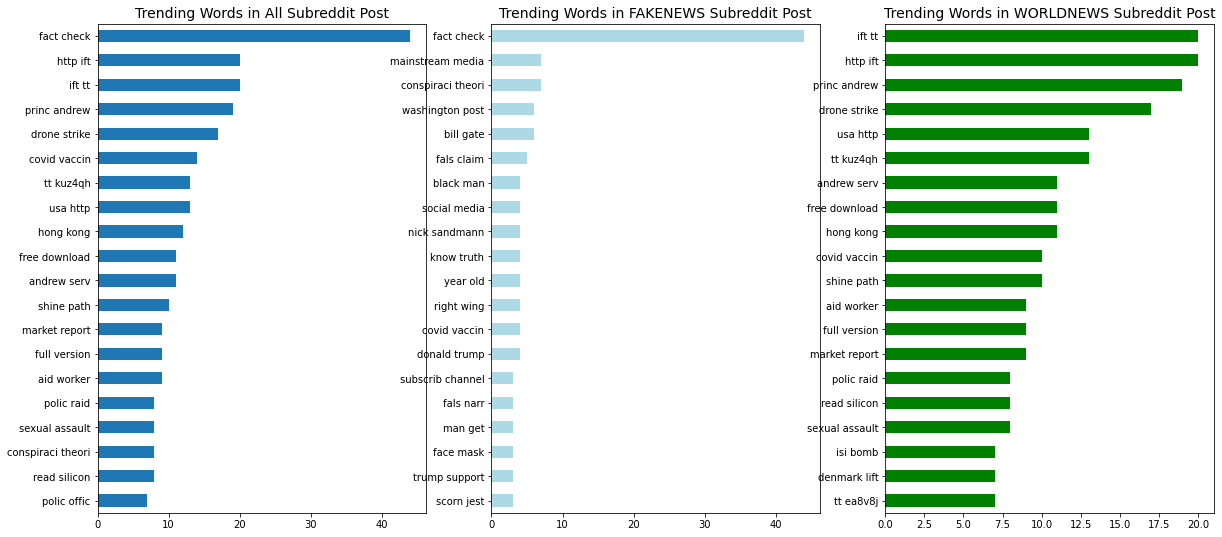

In [85]:
df_main_vocab_n2 = ngram_generator(df_main , 2)
df_world_vocab_n2 = ngram_generator(df_main , 2 , 'world')
df_fake_vocab_n2 = ngram_generator(df_main , 2 , 'fake')

ngram_visualizer(df_main_vocab_n2 , df_fake_vocab_n2 , df_world_vocab_n2)

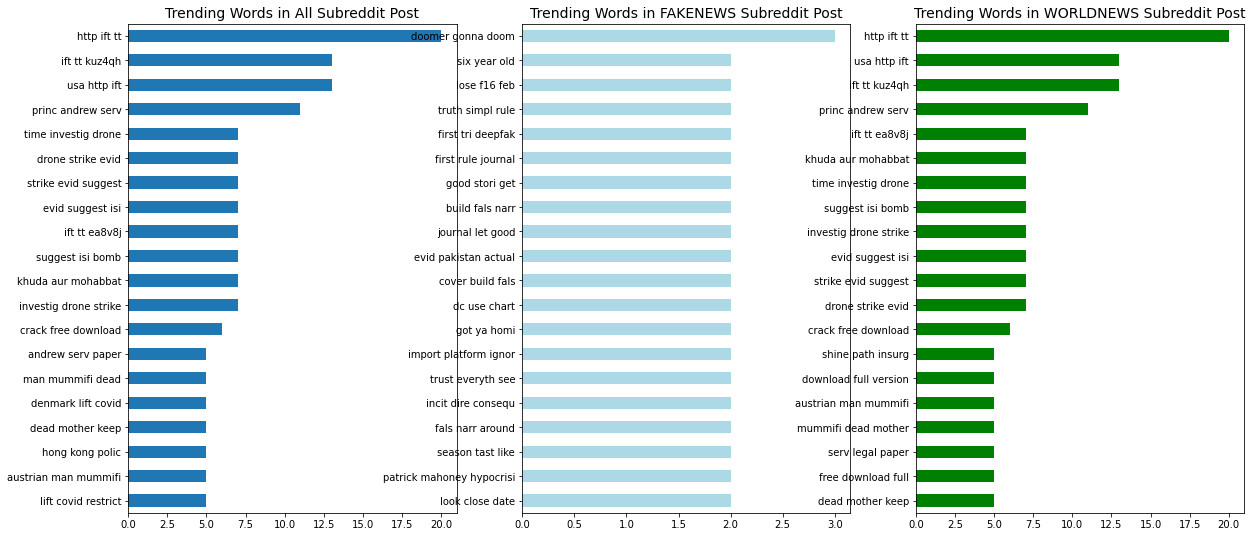

In [86]:
df_main_vocab_n3 = ngram_generator(df_main , 3)
df_world_vocab_n3 = ngram_generator(df_main , 3 , 'world')
df_fake_vocab_n3 = ngram_generator(df_main , 3 , 'fake')

ngram_visualizer(df_main_vocab_n3 , df_fake_vocab_n3 , df_world_vocab_n3)

#3.0 Modelling with Random Forest

In [87]:
X = df_main['title']
y = df_main['subreddit']

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 ,random_state=42 , stratify = y)

print('X_train Shape : ' , X_train.shape)
print('X_test Shape : ' , X_test.shape)
print('y_train Shape : '  , y_train.shape)
print('y_test Shape : ' , y_test.shape)

X_train Shape :  (1492,)
X_test Shape :  (374,)
y_train Shape :  (1492,)
y_test Shape :  (374,)


In [ ]:
%%time
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier())
])

# rf_param_grid = {'min_samples_split' : np.arange(2 , 10 , 2),
#                  'min_samples_leaf' : np.arange(1, 5 , 1),
#                  'n_estimators' : np.arange(50 , 80 , 10),
#                  'max_features' : ['log2' , 'sqrt' , 'auto'],
#                  'max_depth' : [None , 3 , 5]}

param_grid = {'vect__ngram_range' : [(1,1) , (1,2) , (1,3)],
              'tfidf__smooth_idf' : [True , False],
              'tfidf__sublinear_tf' : [True , False],
              'model__min_samples_split' : np.arange(2 , 10 , 2),
              'model__min_samples_leaf' : np.arange(1 , 5 , 1),
              'model__n_estimators' : np.arange(50 , 80 , 10),
              'model__max_features' : ['log2' , 'sqrt' , 'auto'],
              'model__max_depth' : [3,5,7]              
}

# Fitting the model
model = GridSearchCV(estimator = pipe,
                     param_grid = param_grid,
                     cv = 5,
                     n_jobs =-1)

model.fit(X_train , y_train)
# # Model Prediction
y_pred = model.predict(X_test)

In [ ]:
model.best_params_

{'model__max_depth': 7,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 6,
 'model__n_estimators': 70,
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'vect__ngram_range': (1, 1)}

In [ ]:
# Saving the Model
pickle.dump(model , open('RFC_model.pkl' , 'wb'))

In [ ]:
# !wget https://github.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/blob/main/saved_models/RFC_model.pkl

### 3.0.5 Experimenting with New GridSearch parameters
___

In [ ]:
%%time
pipe = Pipeline([('vect', CountVectorizer(min_df = 0.01 , max_df = 0.9)),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier())
])

# rf_param_grid = {'min_samples_split' : np.arange(2 , 10 , 2),
#                  'min_samples_leaf' : np.arange(1, 5 , 1),
#                  'n_estimators' : np.arange(50 , 80 , 10),
#                  'max_features' : ['log2' , 'sqrt' , 'auto'],
#                  'max_depth' : [None , 3 , 5]}

param_grid = {'vect__min_df' : range(5,10),
              'model__min_samples_split' : np.arange(1 , 5 , 1),
              'model__min_samples_leaf' : np.arange(6 , 8 , 1),
              'model__n_estimators' : np.arange(90 , 120 , 10),
              'model__max_features' : ['sqrt'],
              'model__max_depth' : [None]              
}

# Fitting the model
model_2 = GridSearchCV(estimator = pipe,
                       param_grid = param_grid,
                       cv = 5,
                       n_jobs =-1)

model_2.fit(X_train , y_train)
# # Model Prediction
y_pred_2 = model_2.predict(X_test)

CPU times: user 10.9 s, sys: 408 ms, total: 11.3 s
Wall time: 3min 11s


In [ ]:
model_2.best_params_

{'model__max_depth': None,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 6,
 'model__min_samples_split': 4,
 'model__n_estimators': 100,
 'vect__min_df': 8}

In [92]:
model_RFC = Pipeline([('vect', CountVectorizer(min_df = 8 , max_df = 1.0 , ngram_range = (1,1))),
                      ('tfidf', TfidfTransformer('l2')),
                      ('model', RandomForestClassifier(min_samples_split=4,
                                                       min_samples_leaf = 6,
                                                       n_estimators = 100,
                                                       max_features = 'sqrt'))
])
                      
model_RFC.fit(X_train , y_train)
model_RFC_pred = model_RFC.predict(X_test)

{'Accuracy': 0.7540106951871658,
 'F1 Score': 0.8083333333333332,
 'Precision': 0.7348484848484849,
 'Recall': 0.8981481481481481}

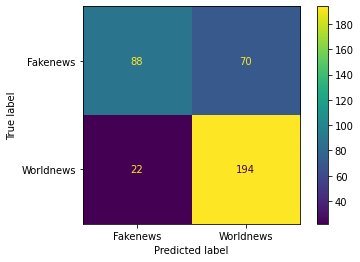

In [93]:
plot_confusion_matrix(model_RFC , X_test , 
                      y_test , 
                      values_format = '.4g',
                      display_labels = ['Fakenews' , 'Worldnews']);

eval_classification(y_true=y_test , y_pred = model_RFC_pred)

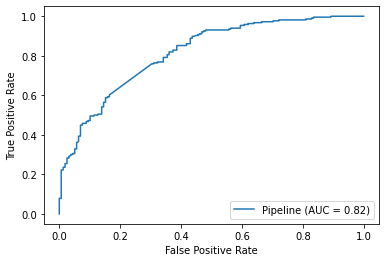

In [94]:
plot_roc_curve(model_RFC , X_test , y_test)

### 3.1 Evaluating Model Score
___

In [ ]:
eval_classification(y_true=y_test , y_pred = y_pred)

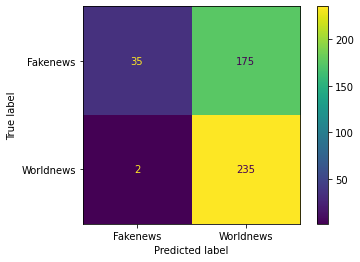

In [ ]:
plot_confusion_matrix(model , X_test , 
                      y_test , 
                      values_format = '.4g',
                      display_labels = ['Fakenews' , 'Worldnews']);

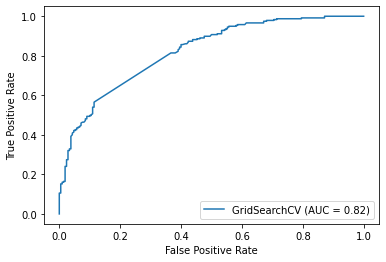

In [ ]:
plot_roc_curve(model , X_test , y_test)

### 3.2 Visualing Most Wrongly Predicted Reddit Post
___

In [95]:
y_proba = model_RFC.predict_proba(X_test)
fakenews_prediction = [y_proba[i][0] for i in range(len(X_test))]

In [96]:
df_prediction  = pd.DataFrame({'Title' : X_test,
                              'Target' : y_test,
                              'Prediction' : model_RFC_pred,
                              'Fakenews_prediction' : fakenews_prediction})

In [97]:
# Visualing Most Wrong Fake News

df_most_right_wrong = df_prediction[df_prediction['Target'] != df_prediction['Prediction']].sort_values(by = 'Fakenews_prediction' , ascending = False)
df_most_right_wrong.tail(10)

,Title,Target,Prediction,Fakenews_prediction
766,care thing written especi western portray china,0,1,0.294547
732,loss word unravel narr behind atlant defund polic shoot tale,0,1,0.273155
462,hate year old sometim,0,1,0.264575
1085,wonder solut could,0,1,0.258446
1486,misconcept cast system india,0,1,0.254403
373,due covid travel restrict american forc hold coup local year,0,1,0.249508
751,polic seiz rifl st loui coupl film wave gun blm protest,0,1,0.231431
717,china put econom sanction us swear enforc global,0,1,0.220510
1334,suprem court su suprem,0,1,0.213820
261,pocahonta first winner hunger game,0,1,0.126730


In [98]:
# Visualing Most Wrong World News

df_most_right_wrong = df_prediction[df_prediction['Target'] != df_prediction['Prediction']].sort_values(by = 'Fakenews_prediction' , ascending = False)
df_most_right_wrong.head(10)

,Title,Target,Prediction,Fakenews_prediction
36,ttp warn pakistani media ask refrain call terrorist dawn,1,0,0.906709
41,cnn jake tapper attack joe biden scold unvaccin,1,0,0.852867
1286,mari trump rip fascist uncl assum even know mean,1,0,0.844500
1398,trump gripe lose ungrat cathol jewish voter call religi advis,1,0,0.831031
529,republican alreadi lie california recal elect rig,1,0,0.777911
1069,pakistan report fresh coronaviru case death,1,0,0.767060
1346,facebook apolog put primat label video black men,1,0,0.732926
1174,rep ocasio cortez give gov greg abbott biolog lesson disgust rape claim,1,0,0.711917
804,watch babycharlotte_99 twitter babychar viral video babychar17 trend twitter page explor,1,0,0.694378
1160,look beauti taj mahal taj mahal video video clip,1,0,0.673006


# 4.0 Modelling with TF Universal Encoder
___

`turning data into numbers (textvectorisation , embedding)` -> `building a model` -> `training the model`

In [99]:
max_vocab_length = 6000 # We have around 4848 from above visualisation
max_length = 30

text_vectorisation = TextVectorization(max_tokens = max_vocab_length,
                                       output_mode = 'int',
                                       output_sequence_length = None,
                                       pad_to_max_tokens = True)

In [100]:
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

In [101]:
random_sentences = random.sample(df_main['title'].to_list() , 3)

for sentence in random_sentences:
  print(sentence)
  print(embed([sentence]))
  print('------------------------------------------------')

pokemoj uranium fan game detect pikachu movi pokemon game tab
tf.Tensor(
[[ 0.04071702  0.027424   -0.03737696  0.00187414  0.01298113 -0.0414779
  -0.0037133  -0.01400729  0.04583285  0.03887452  0.070468   -0.02054037
   0.04384651 -0.03384534  0.02501744  0.05193612 -0.03688893 -0.04269081
   0.00519884 -0.0382883   0.01884882 -0.02817571 -0.03268757  0.04979137
   0.05699249  0.04162545 -0.04168074 -0.04306113 -0.05442421  0.02568703
  -0.03447488 -0.02986573 -0.03988327 -0.06595344 -0.03956981  0.05051745
  -0.05840459 -0.06677171 -0.0175691   0.02491465  0.07404391  0.04941586
  -0.04506861 -0.00239875  0.04312136  0.01195227  0.03328954 -0.03088393
   0.04405959 -0.0694162   0.07478268  0.03085301 -0.04247671 -0.01428462
   0.03280408 -0.02622051  0.004024    0.0667251   0.02639036 -0.07319708
  -0.05140185 -0.06726051  0.01590759  0.00079548 -0.05792603 -0.05328612
   0.04450373  0.06130645 -0.0516564  -0.07390933 -0.02003889  0.01464304
   0.01326208  0.00584158  0.02570515  0

In [102]:
# Create a Keras Layer using Universal Sentence Encoder
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape = [],
                                        dtype = tf.string,
                                        trainable = False,
                                        name = 'tf_model')

In [103]:
tf_model = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64 , activation = 'relu'),
                               layers.Dense(64 , activation = 'relu'),
                               layers.Dense(1 , activation = 'sigmoid')
])

tf_model.compile(optimizer = tf.keras.optimizers.Adam(),
                 loss = tf.keras.losses.BinaryCrossentropy(),
                 metrics = 'accuracy')

In [104]:
tf_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tf_model (KerasLayer)        (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 256,834,881
Trainable params: 37,057
Non-trainable params: 256,797,824
_________________________________________________________________


In [105]:
history_tf = tf_model.fit(X_train,
                         y_train,
                         epochs = 5,
                         validation_data = (X_test , y_test),
                         callbacks = [create_tensorboard_callback('model_log' , 'tf_model')])

Saving Tensorboard log files to model_log/tf_model/20210914-130454
Epoch 1/5
47/47 [==============================] - 4s 30ms/step - loss: 0.6402 - accuracy: 0.6595 - val_loss: 0.5308 - val_accuracy: 0.7861
Epoch 2/5
47/47 [==============================] - 1s 11ms/step - loss: 0.4627 - accuracy: 0.8117 - val_loss: 0.4172 - val_accuracy: 0.8316
Epoch 3/5
47/47 [==============================] - 1s 11ms/step - loss: 0.3933 - accuracy: 0.8311 - val_loss: 0.4177 - val_accuracy: 0.8102
Epoch 4/5
47/47 [==============================] - 1s 12ms/step - loss: 0.3592 - accuracy: 0.8566 - val_loss: 0.4259 - val_accuracy: 0.8048
Epoch 5/5
47/47 [==============================] - 1s 11ms/step - loss: 0.3273 - accuracy: 0.8693 - val_loss: 0.4342 - val_accuracy: 0.8102


In [106]:
tf_model_pred = tf_model.predict(X_test)

In [107]:
eval_classification(y_test , tf.squeeze(tf.round(tf_model_pred)))

{'Accuracy': 0.8101604278074866,
 'F1 Score': 0.839002267573696,
 'Precision': 0.8222222222222222,
 'Recall': 0.8564814814814815}

Confusion matrix, without normalization
[[118  40]
 [ 31 185]]


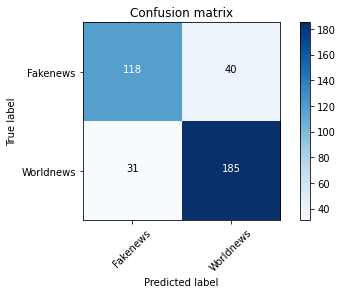

In [108]:
cm = confusion_matrix(y_test , tf.squeeze(tf.round(tf_model_pred)))

tf_confusion_matrix(cm = cm , classes=['Fakenews' , 'Worldnews']);

# 5.0 Modelling with LSTM
___

In [109]:
max_vocab_length = 6000  # Max number of words in our vocab
max_length = 30 # max length our sequence will be (In this case the sequence is a tweet)

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = 'int',
                                    output_sequence_length = max_length,
                                    pad_to_max_tokens = True)

text_vectorizer.adapt(X_train) # so your text vectorization will create a vocab.


embedding = tf.keras.layers.Embedding(input_dim = max_vocab_length,
                                      output_dim = 128,
                                      input_length = max_length)

inputs = layers.Input(shape = (1,) , dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.Bidirectional(layers.LSTM(64 , return_sequences = True))(x)
print(x.shape)
x = layers.Bidirectional(layers.LSTM(32))(x)
print(x.shape)
outputs = layers.Dense(1 , activation = 'sigmoid')(x)
print(x.shape)

lstm_model = tf.keras.Model(inputs , outputs , name = 'lstm_bidrection')

(None, 30, 128)
(None, 30, 128)
(None, 64)
(None, 64)


In [110]:
lstm_model.summary()

Model: "lstm_bidrection"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 30)                0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           768000    
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 128)           98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 908,097
Trainable params: 908,097
Non-trainable params: 0
_____________________________________________

In [111]:
lstm_model.compile(optimizer = tf.keras.optimizers.Adam(),
                   loss = tf.keras.losses.BinaryCrossentropy(),
                   metrics = 'accuracy')

In [112]:
history_lstm = lstm_model.fit(X_train,
                              y_train,
                              epochs = 5,
                              validation_data = (X_test , y_test),
                              callbacks = [create_tensorboard_callback('model_log' , 'lstm_model')])

Saving Tensorboard log files to model_log/lstm_model/20210914-130517
Epoch 1/5
47/47 [==============================] - 13s 130ms/step - loss: 0.6619 - accuracy: 0.6113 - val_loss: 0.5272 - val_accuracy: 0.7807
Epoch 2/5
47/47 [==============================] - 4s 75ms/step - loss: 0.2473 - accuracy: 0.9142 - val_loss: 0.4734 - val_accuracy: 0.7968
Epoch 3/5
47/47 [==============================] - 3s 72ms/step - loss: 0.0705 - accuracy: 0.9806 - val_loss: 0.5748 - val_accuracy: 0.8075
Epoch 4/5
47/47 [==============================] - 4s 75ms/step - loss: 0.0293 - accuracy: 0.9940 - val_loss: 0.7106 - val_accuracy: 0.7995
Epoch 5/5
47/47 [==============================] - 4s 76ms/step - loss: 0.0152 - accuracy: 0.9980 - val_loss: 0.9267 - val_accuracy: 0.7995


In [113]:
lstm_model_pred = lstm_model.predict(X_test)

In [114]:
eval_classification(y_test , tf.squeeze(tf.round(lstm_model_pred)))

{'Accuracy': 0.7994652406417112,
 'F1 Score': 0.8421052631578948,
 'Precision': 0.7722007722007722,
 'Recall': 0.9259259259259259}

Confusion matrix, without normalization
[[ 99  59]
 [ 16 200]]


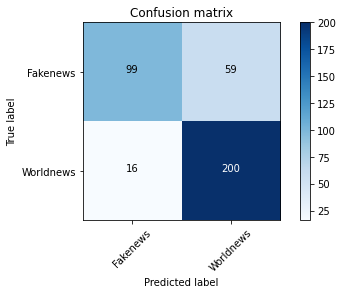

In [115]:
cm = confusion_matrix(y_test , tf.squeeze(tf.round(lstm_model_pred)))

tf_confusion_matrix(cm = cm , classes=['Fakenews' , 'Worldnews']);

In [ ]:
words_in_vocab = text_vectorizer.get_vocabulary()
words_in_vocab[:10]

['',
 '[UNK]',
 'covid',
 'us',
 'trump',
 'vaccin',
 'fact',
 'china',
 'coronaviru',
 'video']

In [116]:
# Get the weight matrix of embedding layer
# (these are the numerical representation of each token in our training data)
# For every unique token or vocab , there is 128 vectors representing it.
embed_weights = lstm_model.get_layer('embedding').get_weights()[0]
embed_weights.shape

(6000, 128)

In [ ]:
# Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

# Download files locally to upload to Embedding Projector
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("embedding_vectors.tsv")
  files.download("embedding_metadata.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Example of Text Vectorisation for WordProjector on Fake news and WorldNews

<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/images/covid.jpeg'>

<img src = 'https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/images/afghan.jpeg'>